In [1]:
%matplotlib inline

from collections import OrderedDict

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('notebook')

km_to_m = 1000.
plt.rcParams.update({'mathtext.default':  'regular' })

In [2]:
def read_obs_seaice_extent():
    '''return sea ice extent in  10^6 sq km'''
    df = pd.read_csv('ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/NH_seaice_extent_final_v2.csv', skiprows=[1])
    df.columns = [c.strip() for c in df.columns]
    df.index = [datetime(int(row['Year']), int(row['Month']), int(row['Day'])) for _, row in df.iterrows()]
    return df['Extent']

obs_extent = read_obs_seaice_extent()

In [3]:
def get_rasm_sea_ice_ts(ds, mask=None, extent_thresh=0.15, minthick=0.1, maxlat=84):
    
    df = pd.DataFrame()
    
    if mask:
        ds = ds.where(mask)
    
    df['extent'] = (ds['aice'].where(
        (ds['aice'] > extent_thresh) & (ds['hi'] > minthick)) * ds['uarea']).sum(
            dim=('ni', 'nj')).to_series() / km_to_m ** 2
    df['area'] = (ds['aice'].where((ds['hi'] > minthick) & (ds['ULAT'] < maxlat)) * ds['uarea']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 2
    df['volume'] = (ds['aice'] * ds['uarea'] * ds['hi']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 3
    df['snow_volume'] = (ds['aice'] * ds['uarea'] * ds['hs']).sum(
        dim=('ni', 'nj')).to_series() / km_to_m ** 3
    
    return df
    
    


In [4]:
rasm_sea_ice_ds = OrderedDict()
rasm_sea_ice_ds['$RASM_{CONTROL}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/ice/monthly_mean_timeseries/R1010RBRbaaa01a.cice.hmm.197909-201412.nc')
rasm_sea_ice_ds['$RASM_{RSI}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/ice/monthly_mean_timeseries/R1010RBRbrsi01a.cice.hmm.197909-201412.nc')
rasm_sea_ice_ds['$RASM_{RSH}$'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/ice/monthly_mean_timeseries/R1010RBRbrsh01a.cice.hmm.197909-201412.nc')
# rasm_sea_ice_ds['R1010RBbaaa01a'] = xr.open_dataset('/raid2/jhamman/projects/RASM/data/processed/R1010RBbaaa01a/ice/monthly_mean_timeseries/R1010RBbaaa01a.cice.hmm.197909-200912.nc')

for k, ds in rasm_sea_ice_ds.items():
    rasm_sea_ice_ds[k].time.values -= np.timedelta64(1, 'D')
    rasm_sea_ice_ds[k] = ds.resample('MS', dim='time', how='first')

In [24]:
dfo = obs_extent.resample('MS').mean().to_frame(name='extent') * km_to_m**2

In [6]:
rasm_sea_ice_dfs = OrderedDict()

for k, ds in rasm_sea_ice_ds.items():
    rasm_sea_ice_dfs[k] = get_rasm_sea_ice_ts(ds)


In [7]:
ds = xr.concat([xr.Dataset(df) for df in rasm_sea_ice_dfs.values()],
               dim=xr.DataArray(list(rasm_sea_ice_ds.keys()),
                                dims=('dataset', ),
                                name='dataset'))
ds.to_netcdf('../data/sea_ice_timeseries.nc')
ds

<xarray.Dataset>
Dimensions:      (dataset: 3, time: 424)
Coordinates:
  * time         (time) datetime64[ns] 1979-09-01 1979-10-01 1979-11-01 ...
  * dataset      (dataset) <U16 '$RASM_{CONTROL}$' '$RASM_{RSI}$' '$RASM_{RSH}$'
Data variables:
    area         (dataset, time) float64 5.585e+06 7.318e+06 9.443e+06 ...
    snow_volume  (dataset, time) float64 1.927e+03 2.406e+03 2.904e+03 ...
    volume       (dataset, time) float64 2.699e+04 2.918e+04 3.142e+04 ...
    extent       (dataset, time) float64 6.906e+06 8.711e+06 1.084e+07 ...

from: https://svn.nps.edu/repos/racm/rasm/trunk/scripts/rasm_utils/Post_processing/matlab/NPS_scripts/RASM_sea_ice/functions/RASM_sea_ice_extent_volume_cesm.m

```
for i=1:length(nce.time.data);

  if oldconc
   cellextent=nca.tarea.data(squeeze(nca.(afield).data(i,:,:))>15 & ...
                             squeeze(ncs.(sfield).data(i,:,:))>minthick);
  else
   cellextent=nca.tarea.data(squeeze(nca.(afield).data(i,:,:))>0.15 & ...
                             squeeze(ncs.(sfield).data(i,:,:))>minthick);
  end
  nce.extent.data(i)=sum(cellextent(:))./10^6;
 
  if oldconc
   cellarea=nca.tarea.data.*squeeze(nca.(afield).data(i,:,:))/100;
  else
   cellarea=nca.tarea.data.*squeeze(nca.(afield).data(i,:,:));
  end

  dvec=datevec(nce.time.data(i));
  nce.area.data(i)=NaN;
  nce.area84.data(i)=NaN;

  if dvec(1)<1988 
   if oldconc
    cellarea=cellarea(squeeze(nca.(afield).data(i,:,:))>15 & ...
                      nca.latitude.data(:,:)<84 & ...
                      squeeze(ncs.(sfield).data(i,:,:))>minthick);
   else
    cellarea=cellarea(squeeze(nca.(afield).data(i,:,:))>0.15 & ...
                      nca.latitude.data(:,:)<84 & ...
                      squeeze(ncs.(sfield).data(i,:,:))>minthick);
   end
   nce.area84.data(i)=sum(cellarea(:))./10^6;
  else
   if oldconc
    cellarea=cellarea(squeeze(nca.(afield).data(i,:,:))>15 & ...
                      nca.latitude.data(:,:)<87 & ...
                      squeeze(ncs.(sfield).data(i,:,:))>minthick);
   else
    cellarea=cellarea(squeeze(nca.(afield).data(i,:,:))>0.15 & ...
                      nca.latitude.data(:,:)<87 & ...
                      squeeze(ncs.(sfield).data(i,:,:))>minthick);
   end
   nce.area.data(i)=sum(cellarea(:))./10^6;
  end

  cellvolume=ncs.tarea.data.*squeeze(ncs.(sfield).data(i,:,:));
  if oldconc
   cellvolume=cellvolume(squeeze(nca.(afield).data(i,:,:))>15);
  else
   cellvolume=cellvolume(squeeze(nca.(afield).data(i,:,:))>0.15);
  end
  nce.volume.data(i)=sum(cellvolume(~isnan(cellvolume)))./10^9;

  cellvolume=ncs.tarea.data.*squeeze(ncsnow.(snowfield).data(i,:,:));
  if oldconc
   cellvolume=cellvolume(squeeze(nca.(afield).data(i,:,:))>15);
  else
   cellvolume=cellvolume(squeeze(nca.(afield).data(i,:,:))>0.15);
  end
  nce.snowvolume.data(i)=sum(cellvolume(~isnan(cellvolume)))./10^9;
  ```

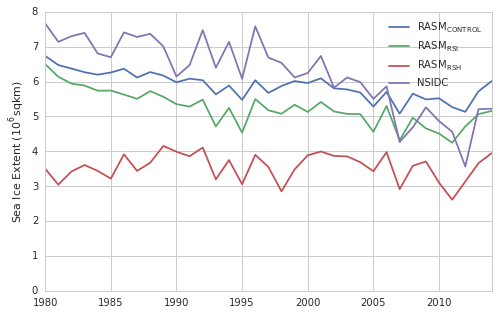

In [8]:
plt.figure(figsize=(8, 5))

for k, df in rasm_sea_ice_dfs.items():
    (df['extent']['1980':].resample('AS').min() / 1e6).plot(label=k)
obs_extent['1980' : '2014'].resample('MS').mean().resample('AS').min().plot(label='NSIDC')
plt.ylim(ymin=0)
plt.legend()

plt.ylabel('Sea Ice Extent ($10^6 sq km$)')
plt.xlabel('')

In [27]:
rasm_sea_ice_dfs['NSIDC'] = dfo

area 'area'
volume 'volume'
snow_volume 'snow_volume'


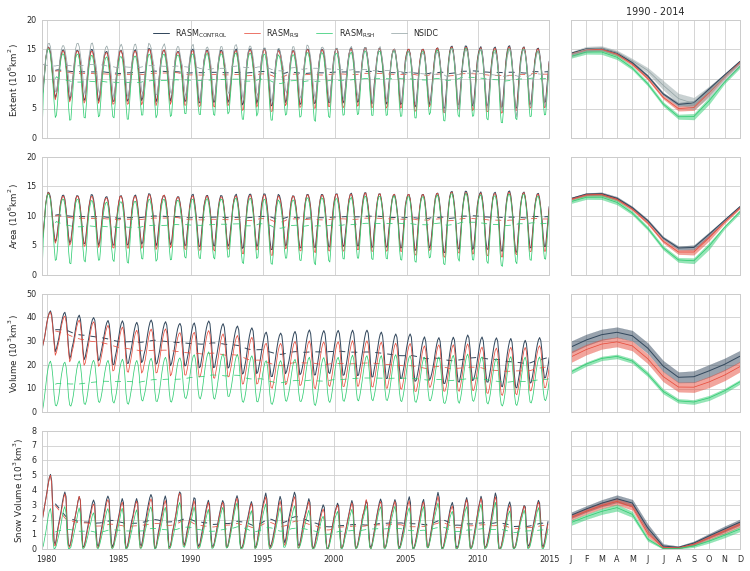

In [29]:
rows = ['extent', 'area', 'volume', 'snow_volume']
ylabels = {'extent': 'Extent ($10^6 km^2$)', 'area': 'Area ($10^6 km^2$)',
           'volume': 'Volume ($10^3 km^3$)', 'snow_volume': 'Snow Volume ($10^3 km^3$)'}
ylims = {'extent': (0, 20), 'area': (0, 20),
         'volume': (0, 50), 'snow_volume': (0, 8)}
colors = dict(zip(['NSIDC', '$RASM_{RSH}$', '$RASM_{RSI}$', '$RASM_{CONTROL}$'],
                  ["#95a5a6", "#2ecc71", "#e74c3c", "#34495e"]))
lws = dict(zip(['NSIDC', '$RASM_{RSH}$', '$RASM_{RSI}$', '$RASM_{CONTROL}$'],
               [0.75, 0.75, 0.75, 1]))
scale = {'extent': 10**6, 'area': 10**6,
         'volume': 10**3, 'snow_volume': 10**3}

from matplotlib import gridspec
from matplotlib.dates import YearLocator

sns.set_style('whitegrid')
sns.set_context('paper')

fig = plt.figure(figsize=(10.5, 8)) 
gs = gridspec.GridSpec(len(rows), 2, width_ratios=[3, 1]) 

bot_ax1 = plt.subplot(gs[-1, 0])
bot_ax2 = plt.subplot(gs[-1, 1])
    
# annual_slice = slice('1990', '2001')
# annual_slice = slice('2000', '2009')
annual_slice = slice('1990', '2014')


year_x_ticks = pd.date_range('1980', '2015', freq='5AS')
    
for i, var in enumerate(rows):
    ax1 = plt.subplot(gs[i, 0], sharex=bot_ax1)
    ax2 = plt.subplot(gs[i, 1], sharey=ax1, sharex=bot_ax2)
    
    for label, df in rasm_sea_ice_dfs.items():
        try:
            # Timeseries
            s = df[var] / scale[var]
            s.plot(ax=ax1, c=colors[label], label=label, lw=lws[label])
            s.rolling(12, min_periods=12, center=False).mean().plot(
                ax=ax1, c=colors[label], lw=lws[label], ls='--', label='')
            ax1.set_ylabel(ylabels[var])
            ax1.set_ylim(ylims[var])
            ax1.set_xticks(year_x_ticks)
            ax1.set_xticklabels(year_x_ticks.year)

            # Seasonal cycle
            s_group = s[annual_slice].groupby(lambda x: x.month) 
            m = s_group.mean()
            std = s_group.std() * 2 # (two standard deviations)
            m.plot(ax=ax2, color=colors[label], label=label, lw=lws[label])
            ax2.fill_between(m.index, m + std/2, m - std/2, alpha=0.5, color=colors[label])
            ax2.set_xticks(range(1, 13))
            ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        except Exception as e:
            print(var, e)
#             raise
        
        ax1.set_xlabel('')
    
    if i == 0:
        ax1.legend(loc='upper center', ncol=4, frameon=False)
        ax2.set_title('%s - %s' % (annual_slice.start, annual_slice.stop))
        

fig.tight_layout()

fig.savefig('../figs/sea_ice_timeseries.png', dpi=300)

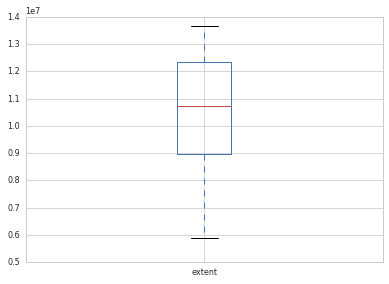

In [32]:
dfo[dfo.index.month > 9].plot(kind='box')

In [67]:
extent_df = pd.DataFrame()

for k, df in rasm_sea_ice_dfs.items():
    extent_df[k] = df['extent']['1985':'2015'] / km_to_m**2

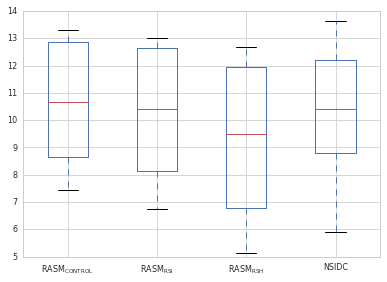

In [87]:
extent_df[extent_df.index.month > 9].plot(kind='box')

In [69]:
df = pd.melt(extent_df[extent_df.index.month > 9] , value_name='extent')
df.head()

,variable,extent
0,$RASM_{CONTROL}$,8.463892
1,$RASM_{CONTROL}$,10.403540
2,$RASM_{CONTROL}$,12.533408
3,$RASM_{CONTROL}$,8.936628
4,$RASM_{CONTROL}$,10.736206


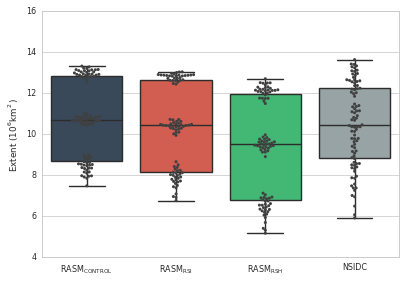

In [85]:

sns.set_context('paper')
ax = sns.boxplot(x="variable", y="extent", data=df, palette=colors, )
ax = sns.swarmplot(x="variable", y="extent", data=df, color=".25", size=3, )

plt.ylabel('Extent ($10^6 km^2$)')
plt.xlabel('')
